In [1]:
# hyperparameters
datapath = './adult.csv'
savedir = './ckpts/fred'
learning_rate = 5e-4
batch_size = 16
max_length = 140
epochs = 1
num_samples = 500
random_state = 42
test_ratio = 0.25 # this fraction of num_samples will be taken as the test set during evaluation

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import transformers
from torch import nn
import torch
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from matplotlib import pyplot as plt
from tqdm import tqdm 
import re
from sklearn import preprocessing, pipeline, ensemble, compose, model_selection
import os
if not os.path.isdir(savedir):
    os.makedirs(savedir, exist_ok=True)

In [3]:
model = transformers.AutoModelForCausalLM.from_pretrained('distilgpt2')
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
special_tokens_dict = {"bos_token": "<BOS>", 'eos_token': '<EOS>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
# Move the model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.resize_token_embeddings(len(tokenizer))

# Load the dataset
cols = ['income', 'age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
        'race','sex','capital-gain','capital-loss','hours-per-week'] #all columns in order
ords = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'] # ordinal cols  in order
nums = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', ] # numerical cols in order
labs = ['income'] # label col
real = pd.read_csv(datapath)[cols]
realtrain, realtest = model_selection.train_test_split(real, test_size=int(num_samples*test_ratio), shuffle=True, random_state=random_state)
'real train/test sizes:', realtrain.shape, realtest.shape

/mnt/data/sonia/miniconda3/envs/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/mnt/data/sonia/miniconda3/envs/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('real train/test sizes:', (48717, 14), (125, 14))

## Training

In [4]:
def row_to_col_sentences(row):
    return [str(col).strip() + " is " + str(val).strip() + '.<EOS>' for col, val in zip(row.index, row.values)]

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=100):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = 100

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = text_data[idx]
        text = tokenizer.bos_token + ''.join(text)
        # print(text)
        tokenized_text = self.tokenizer(text, truncation=True, max_length=self.max_length, padding='max_length', return_tensors='pt')
        return tokenized_text.input_ids.squeeze(), tokenized_text.attention_mask.squeeze()
            
            
text_data = real.apply(row_to_col_sentences, axis=1).tolist()
dataset = TextDataset(text_data, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
model.train()
optimizer = AdamW(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs): 
    for batch in tqdm(dataloader):
        # print(batch)
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    torch.save(model.state_dict(), os.path.join(savedir, f'model-e{epoch}.pt'))

  0%|          | 0/3053 [00:00<?, ?it/s]

  7%|▋         | 201/3053 [01:09<16:25,  2.89it/s]


KeyboardInterrupt: 

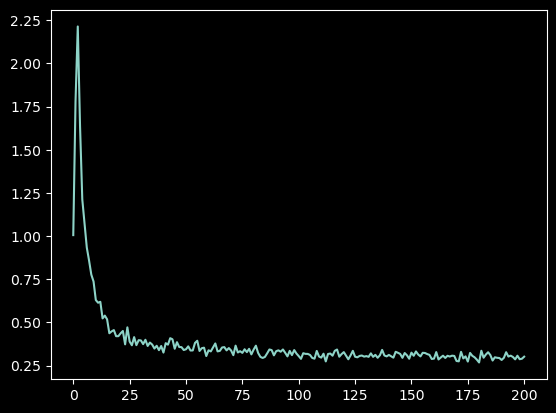

In [9]:
plt.plot(losses)

## Sampling

In [10]:
# model.load_state_dict(torch.load(os.path.join(savedir, f'model-e{epochs}.pt')))
model.eval()
# Move the model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [11]:
tokenizer.batch_decode(model.generate(max_length=max_length))[0]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


'<|endoftext|>income is <=50K.<EOS>age is 30.<EOS>workclass is Private.<EOS>fnlwgt is 173593.<EOS>education is HS-grad.<EOS>education-num is 9.<EOS>marital-status is Married-civ-spouse.<EOS>occupation is Craft-repair.<EOS>relationship is Husband.<EOS>race is White.<EOS>sex is Male.<EOS>capital-gain is 0.<EOS>capital-loss is 0.<EOS>hours-per-week is 40.<EOS><|endoftext|>'

In [12]:
%%capture
samples = []
for i in range(num_samples):
    # tokenizer.batch_decode(model.generate(max_length=max_length))[0] # search
    samp = tokenizer.batch_decode(model.generate(do_sample=True, num_beams=1, max_length=max_length))[0] #sample
    samples.append(samp)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` t

In [13]:
# parsing
pattern = r'^\<\|endoftext\|\>income is (.+?)\.<EOS>age is (\?|\d+)\.<EOS>workclass is (.+)\.<EOS>fnlwgt is (\?|\d+)\.<EOS>education is (.+)\.<EOS>' +\
             r'education-num is (\?|\d+)\.<EOS>marital-status is (.+)\.<EOS>occupation is (.+)\.<EOS>relationship is (.+)\.<EOS>' +\
             r'race is (.+)\.<EOS>sex is (.+)\.<EOS>capital-gain is (\?|\d+)\.<EOS>capital-loss is (\?|\d+)\.<EOS>' +\
             r'hours-per-week is (\?|\d+)\.<EOS>.?'
parsed = []
for raw in samples:
    vals = re.findall(pattern, raw)
    if len(vals) == 1:
        parsed.append(vals[0])
len(parsed)

477

In [14]:
synth = pd.DataFrame(parsed, columns=cols)
synth.head()

,income,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,<=50K,26,Private,172909,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,44
1,>50K,52,Self-emp-not-inc,212826,Bachelors,13,Never-married,Prof-specialty,Other-relative,Black,Female,0,0,40
2,<=50K,18,Private,124933,HS-grad,9,Never-married,Protective-serv,Not-in-family,White,Male,907,0,35
3,>50K,62,Private,230826,Some-college,10,Married-civ-spouse,Other-service,Wife,White,Female,0,0,20
4,<=50K,25,Private,116416,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,40


In [15]:
ordvals = {col:set(real[col].unique()) for col in ords+labs} #+labs to make sure labels match too
for col in ordvals:
    ordvals[col] = [val.strip() for val in ordvals[col]]
    
for col in ordvals:
    synth = synth[synth[col].isin(ordvals[col])]
    print(col, len(synth))
    
print(num_samples-len(synth), 'samples thrown out')

workclass 477
education 473
marital-status 471
occupation 466
relationship 464
race 461
sex 461
income 460
40 samples thrown out


In [16]:
synth.to_csv(os.path.join(savedir, 'synth.csv'), index=False)

## ML Efficacy

In [17]:
synthtrain, synthtest = model_selection.train_test_split(synth, test_size=test_ratio, shuffle=True, random_state=random_state)
'synth train/test sizes:', synthtrain.shape, synthtest.shape

('synth train/test sizes:', (345, 14), (115, 14))

In [18]:
min_dataset_size = min(len(realtrain), len(synthtrain))
realtrain = realtrain.sample(min_dataset_size, random_state=random_state)
synthtrain=synthtrain.sample(min_dataset_size, random_state=random_state)
print(realtrain.shape, synthtrain.shape)
datadict = {'real':realtrain, 'synth':synthtrain}
datadicttest = {'real':realtest, 'synth':synthtest}
datadict.keys(), datadicttest.keys()

(345, 14) (345, 14)


(dict_keys(['real', 'synth']), dict_keys(['real', 'synth']))

In [19]:
# for each ord column, get all unique values occurign in real/synth, train/test
categories = []
for name in ords:
    s = set(real[name].unique().tolist())
    s.update(synth[name].unique().tolist())
    
    categories.append( list(s) )

ordenc = preprocessing.OrdinalEncoder(categories=categories)
numenc = preprocessing.StandardScaler()
lb = preprocessing.LabelBinarizer()

In [20]:
def create_pipeline(trainset):
    rfc = ensemble.RandomForestClassifier(n_estimators=10, max_depth=4)
    preprocessing_pipeline = compose.ColumnTransformer([
        ("ordinal_preprocessor", ordenc, ords),
        ("numerical_preprocessor", numenc, nums),
    ])
    complete_pipeline = pipeline.Pipeline([
        ("preprocessor", preprocessing_pipeline),
        ("estimator", rfc)
    ])
    
    preprocessed_labels = lb.fit_transform(trainset[labs].values.ravel())
    complete_pipeline.fit(trainset[ords+nums], preprocessed_labels)
    return complete_pipeline

In [21]:
# create random forest pipelines
rfdict = {}
for src in datadict.keys():
    print(src)
    rfdict[src] = create_pipeline(datadict[src])

real
synth


/mnt/data/sonia/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/mnt/data/sonia/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [22]:
for data in datadicttest.keys():
    labels = lb.fit_transform(datadicttest[data][labs])
    for model in rfdict.keys():
        score = rfdict[model].score(datadicttest[data][ords+nums], labels)
        print(f'{model} on {data}: \t\t\t{score}')

real on real: 			0.856
synth on real: 			0.68
real on synth: 			0.6521739130434783
synth on synth: 			0.7304347826086957
